### The Mectron Load Line

In this notebook, we'll explore load line placement using extracted data from the 25L6G plate characteristic curves. The interactive example allows changing Ia, Va, n and speaker impedance while drawing and calculating output performance estimations.

The code then determines the transfer characteristic from the selected operating point and extracted data. It then calculates the circuit transient response highlighting second harmonic distortion. Finally, the user can play 3 normalized audio levels with varying levels of second harmonic to demonstrate what a distorted sine wave sounds like.
<hr>
<b>Mectron MPA-II Schematic</b><br>
<img src='mpa-ii-pentode-schematic.jpg'><br>
<br><b>25L6GT - GE ET-T867</b><br>
<img src='25L6GT EC2=110V.png'>
<hr>
#### Data Extraction

In [9]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import interpolate
import math
from ipywidgets import *
from scipy.fftpack import fft
from scipy.optimize import fsolve

# used engauge to extract plot data from datasheet
fn = "25L6GT EC2=110V.csv"
datasheetCurveData = pd.read_csv(fn)

colnames = datasheetCurveData.columns.values
colcount = len(colnames)
rowcount = len(datasheetCurveData[colnames[0]])

# do a little clean up
# remove negative values of plate current
for i in range(1,colcount):
    for j in range(rowcount):
        if datasheetCurveData[colnames[i]][j] < 0.00:
            datasheetCurveData[colnames[i]][j] = 0.0
            
# engauge adds bogus points on curves where plate voltage is greater than curve
# scan through array data column at a time, find point where engauge starts duplicating data
# calculate slope and y-axis intercept (m, b) then fill data past that point with a line
for i in range(1,colcount):
    m = 0
    b = 0
    for j in range(rowcount):
        if datasheetCurveData[colnames[i]][j] > 0.01:
            try:
                if m == 0:
                    if datasheetCurveData[colnames[i]][j] == datasheetCurveData[colnames[i]][j+40]:
                        # now need to find the average of the past slopes
                        slopeCount = 10
                        sum = 0
                        for k in range(j-slopeCount,j):
                            sum += (datasheetCurveData[colnames[i]][k] - datasheetCurveData[colnames[i]][k-1])/(datasheetCurveData['PlateVoltage'][k] - datasheetCurveData['PlateVoltage'][k-1])
                        m = sum / slopeCount;
                        if m < 0.0:
                            m = 0.0;
                        b = datasheetCurveData[colnames[i]][j] - m*datasheetCurveData['PlateVoltage'][j]
                        # print j,datasheetCurveData[colnames[i]][j],m,b
                if m != 0:
                    datasheetCurveData[colnames[i]][j] = m*datasheetCurveData['PlateVoltage'][j] + b
            except KeyError:
                pass # j+2 is now > rowcount for the higher curves

In [10]:
datasheetCurveData.head(5)

,PlateVoltage,0V,-2V,-4V,-6V,-8V,-10V,-12V,-14V,-16V
0,-5.000000e-15,0.00035,0.00000,0.00000,0.00035,0.00241,0.00034,0.00000,0.00414,0.00000
1,1.370000e+00,0.00883,0.00777,0.00283,0.00454,0.00241,0.00685,0.00832,0.00414,0.00090
2,2.750000e+00,0.01925,0.01529,0.00972,0.01245,0.01287,0.01214,0.00994,0.00414,0.00194
3,4.120000e+00,0.02488,0.02189,0.01624,0.01919,0.01724,0.01567,0.01069,0.00470,0.00242
4,5.490000e+00,0.02873,0.02752,0.02222,0.02449,0.02037,0.01755,0.01108,0.00513,0.00269


In [11]:
datasheetCurveData.tail(5)

,PlateVoltage,0V,-2V,-4V,-6V,-8V,-10V,-12V,-14V,-16V
355,487.64,0.15476,0.127839,0.099920,0.07548,0.057248,0.03756,0.02516,0.014541,0.00737
356,489.01,0.15476,0.127864,0.099944,0.07548,0.057285,0.03756,0.02516,0.014551,0.00734
357,490.38,0.15476,0.127889,0.099969,0.07548,0.057322,0.03756,0.02516,0.014561,0.00731
358,491.76,0.15476,0.127914,0.099994,0.07548,0.057359,0.03756,0.02516,0.014571,0.00728
359,493.13,0.15476,0.127939,0.100019,0.07548,0.057396,0.03756,0.02516,0.014581,0.00725


<hr>
#### Load Line Placement

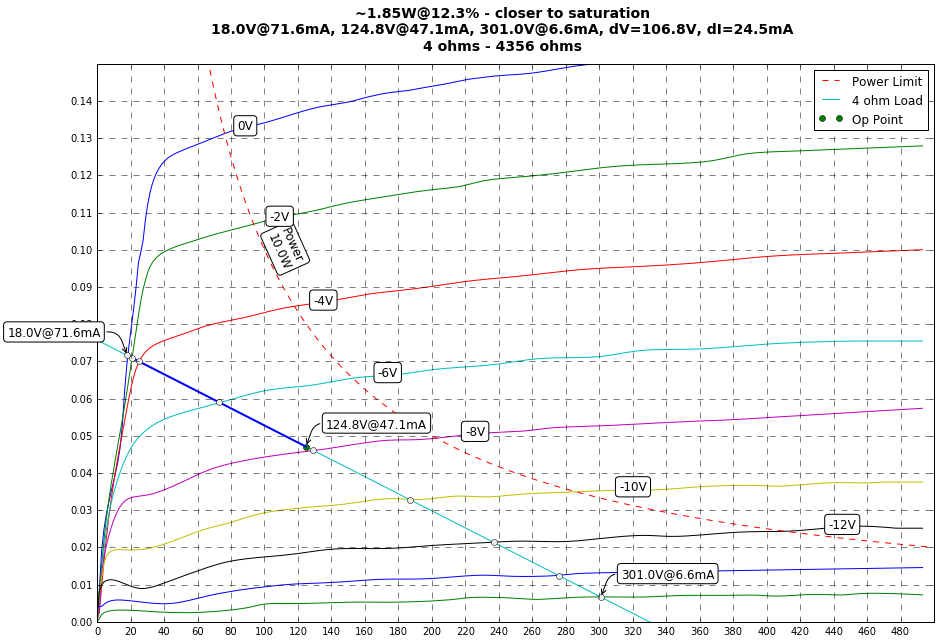

In [17]:
#initial values
Ia = 0.0471  #plate current mA
Va = 126.6   #plate voltage V
Rl = 4       #speaker impedance
n  = 33      #pri/sec turns ratio

VaMAX = 500.0
IaMAX = 0.15
GraphWidth = 840 # get these from jpg size 
GraphHeight = 560

# later, we find intersection of loadline with plate current curves by resampling
# so all have the same x values.
# http://stackoverflow.com/questions/17928452/find-all-intersections-of-xy-data-point-graph-with-numpy
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html

PlateVoltages = np.arange(0,VaMAX,1.0)

saturationCurveVoltage = '0V'
cutoffCurveVoltage = '-16V'

# creating 1D interpolation functions from the datasheet extracted curves
iaf = {}
for i in range(1,colcount):
    iaf[colnames[i]] = {'valueAt': None,'loadLineIntersectionV':0,'loadLineIntersectionI':0}
    iaf[colnames[i]]['valueAt'] = interpolate.interp1d(datasheetCurveData['PlateVoltage'].tolist(), 
                                            datasheetCurveData[colnames[i]].tolist())

def plot(_Ia,_Va,_Rl,_n):
    global i0intersect, i16intersect,Ia,Va,Rl,n,b,m
    Ia = _Ia # set the slider values to global
    Va = _Va
    Rl = _Rl
    n  = _n

    # plot the csv colums versus plate/anode voltage
    fig = plt.figure(figsize=(15, 10))
    null = [plt.plot(datasheetCurveData['PlateVoltage'],
                     datasheetCurveData[colnames[x]],label='') for x in range(1,colcount)]
    plt.grid(linestyle='--', linewidth=0.5)
    null = plt.xticks(np.arange(0,VaMAX,20))
    null = plt.yticks(np.arange(0,IaMAX,0.01))

    # plot power dissipation limit curve
    Pd = 10.0 # 10W
    null = plt.plot(PlateVoltages, Pd/PlateVoltages,label='Power Limit',linestyle='--')

    null = plt.xlim([0,VaMAX])
    null = plt.ylim([0,IaMAX])

    def placeLabel(plt,text,x,y,angle):
        null = plt.annotate(s=text,
                        rotation=angle,
                        xy=(x,y),
                        xycoords='data',
                        xytext=(0,0),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        # arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=70,rad=10")
                           )


    powerLimitVoltage = 100.0
    slope = -Pd/(powerLimitVoltage*powerLimitVoltage)
    graphSlope = slope*(GraphHeight/IaMAX)/(GraphWidth/VaMAX)
    angle = (180.0/np.pi) * np.arctan(graphSlope)
    placeLabel(plt,"Power\n%.1fW"%Pd,powerLimitVoltage,Pd/powerLimitVoltage,angle)

    for i in range(1,colcount):
        l = colnames[i]
        for j in range(rowcount):
            if datasheetCurveData['PlateVoltage'][j]*datasheetCurveData[colnames[i]][j] > (Pd+1.0):
                placeLabel(plt,l,datasheetCurveData['PlateVoltage'][j],datasheetCurveData[colnames[i]][j],0)
                break

    plateImpedance = float(Rl * n**2)

    m = -1/plateImpedance
    b = Ia + Va/plateImpedance
    ll = m*PlateVoltages+b

    null = plt.plot(PlateVoltages,ll,label='%d ohm Load'%Rl)
    null = plt.plot(Va,Ia, 'or',label='Op Point',color='g')


    for i in range(1,colcount):
        mindiff = 10
        for v in PlateVoltages:
            try:
                ia = iaf[colnames[i]]['valueAt'](v)
                iall = m*v+b
                diff = abs(ia - iall)

                if diff < mindiff:
                    vinter = v
                    iinter = iall
                    mindiff = diff
            except ValueError:
                pass

        iaf[colnames[i]]['loadLineIntersectionV'] = vinter
        iaf[colnames[i]]['loadLineIntersectionI'] = iinter

        if colnames[i] == cutoffCurveVoltage:
            break

    vsat = iaf[colnames[1]]['loadLineIntersectionV']
    isat = iaf[colnames[1]]['loadLineIntersectionI']
    null = plt.annotate(s="%.1fV@%.1fmA"%(vsat,isat*1000),
                        xy=(vsat,isat),
                        xycoords='data',
                        xytext=(-120,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=110,rad=10"))
    null = plt.annotate(s="%.1fV@%.1fmA"%(Va,Ia*1000),
                        xy=(Va,Ia),
                        xycoords='data',
                        xytext=(20,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=70,rad=10"))
    vcut = iaf[cutoffCurveVoltage]['loadLineIntersectionV']
    icut = iaf[cutoffCurveVoltage]['loadLineIntersectionI']
    null = plt.annotate(s="%.1fV@%.1fmA"%(vcut,icut*1000),
                        xy=(vcut,icut),
                        xycoords='data',
                        xytext=(20,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=70,rad=10"))


    # from RCA RC-22 P19
    distortion = (((icut+isat)/2 - Ia)/(icut-isat))*100

    dvlower = Va - vsat
    dilower = isat - Ia
    dvhigher = vcut - Va
    dihigher = Ia - icut

    if dvlower < dvhigher:
        # closer to saturation
        Pout =  dvlower*(1/math.sqrt(2))*dilower
        title = "~%.2fW - closer to saturation\n%.1fV@%.1fmA, %.1fV@%.1fmA, %.1fV@%.1fmA, dV=%.1fV, dI=%.1fmA\n%d ohms - %d ohms"%(Pout,
                                                                            vsat,isat*1000,
                                                                            Va,Ia*1000,
                                                                            vcut,icut*1000,
                                                                            dvlower,dilower*1000,
                                                                            Rl,
                                                                            plateImpedance)
        null = plt.plot((vsat,Va),(isat,Ia),linewidth=2,color='b')
    else:
        # closer to cutoff
        Pout =  (vcut-Va)*(1/math.sqrt(2))*(Ia-icut)
        title = "~%.2fW - closer to cutoff\n%.1fV@%.1fmA, %.1fV@%.1fmA, %.1fV@%.1fmA, dV=%.1fV, dI=%.1fmA\n%d ohms - %d ohms"%(Pout,
                                                                        vsat,isat*1000,
                                                                        Va,Ia*1000,
                                                                        vcut,icut*1000,
                                                                        dvhigher,dihigher*1000,
                                                                        Rl,
                                                                        plateImpedance)
        null = plt.plot((Va,vcut),(Ia,icut),linewidth=2,color='b')



    for i in range(1,colcount):
        if iaf[colnames[i]]['loadLineIntersectionV']:
            vinter = iaf[colnames[i]]['loadLineIntersectionV']
            iinter = iaf[colnames[i]]['loadLineIntersectionI']
            null = plt.plot(vinter,iinter,'or',color='#EEEEEE')


    null = plt.suptitle(title,fontsize=14, fontweight='bold')
    null = plt.legend()

null = interact(plot,
             _Ia=widgets.FloatSlider(min=0.01,max=0.1,step=0.0025,value=Ia),
             _Va=widgets.FloatSlider(min=50,max=300,step=5,value=124.75),
             _Rl=widgets.FloatSlider(min=2,max=16,step=2,value=4),
             _n=widgets.FloatSlider(min=10,max=40,step=1,value=33))

From RCA RC-22, p19,
$$THD\% = \large{\frac{\frac{I_{max}+I_{min}}{2}-I_O}{I_{max}-I_{min}} * 100}$$<br>
<br><b>We can not use</b> this approximation/simplified THD equation for pentodes because harmonic content is not primarily 2nd. Let's show why.

<hr>
### Moving on to the transfer characteristic

We'll take the load line/curve intersections shown in graph above and plot those, $v_g$ versus $i_a$.

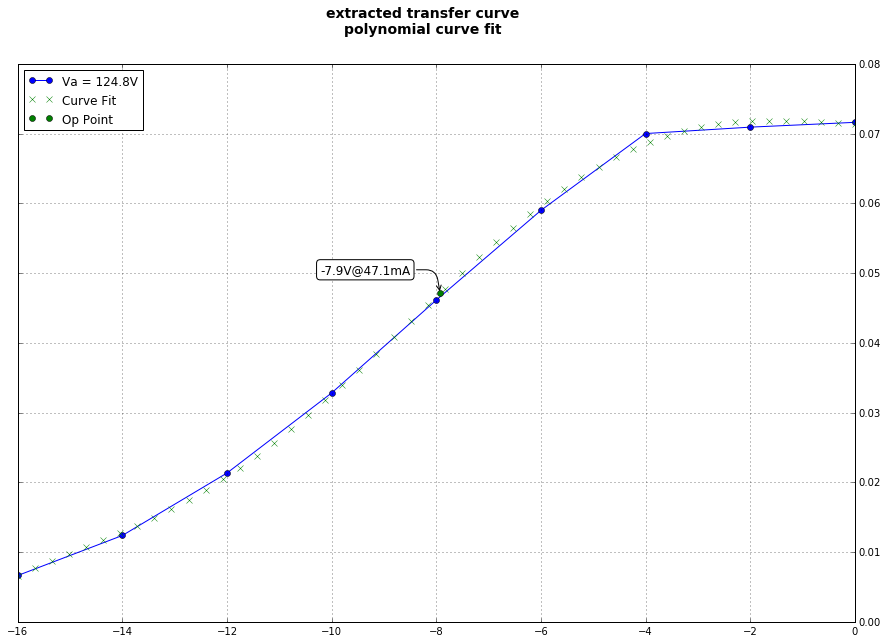

In [13]:
vgLimitLow = -16.0

fig = plt.figure(figsize=(15, 10))

x = []
y = []
for i in range(1,colcount):
    if iaf[colnames[i]]['loadLineIntersectionV'] > 0:
        x.append(float(colnames[i][:-1]))
        y.append(iaf[colnames[i]]['loadLineIntersectionI'])

plt.plot(x,y,label="Va = %.1fV"%Va,marker='o')
        
plt.tick_params(axis='y', which='both', labelleft='off', labelright='on')
plt.grid(True)

'''
# use this to plot vals in openoffice to pick the poly curvefit order
for i in range(len(x)):
    print "%.6f,%0.6f"%(x[i],y[i])
'''

coeff = np.polyfit(x, y, 5)

def iaGet(v):
    sum = 0
    for a in coeff[:-1]:
        sum = (sum + a)*v
    sum += coeff[-1]
    return sum

def func(v):
    global coeff,Ia
    return iaGet(v) - Ia

title = "extracted transfer curve\npolynomial curve fit"

x = np.linspace(vgLimitLow,0)
y = []
for v in x:
    y.append(iaGet(v))

null = plt.plot(x,y,marker='x',label="Curve Fit",linestyle='None')

# using the curve-fitted curve, find Vg at Ia
Vg = fsolve(func,8.0)

null = plt.annotate(s="%.1fV@%.1fmA"%(Vg,Ia*1000),
                        xy=(Vg,Ia),
                        xycoords='data',
                        xytext=(-120,20),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=100,rad=10"))

null = plt.plot(Vg,Ia, 'or',label='Op Point',color='g')
null = plt.suptitle(title,fontsize=14, fontweight='bold')
null = plt.xlim([vgLimitLow,0])
null = plt.legend(loc='upper left')

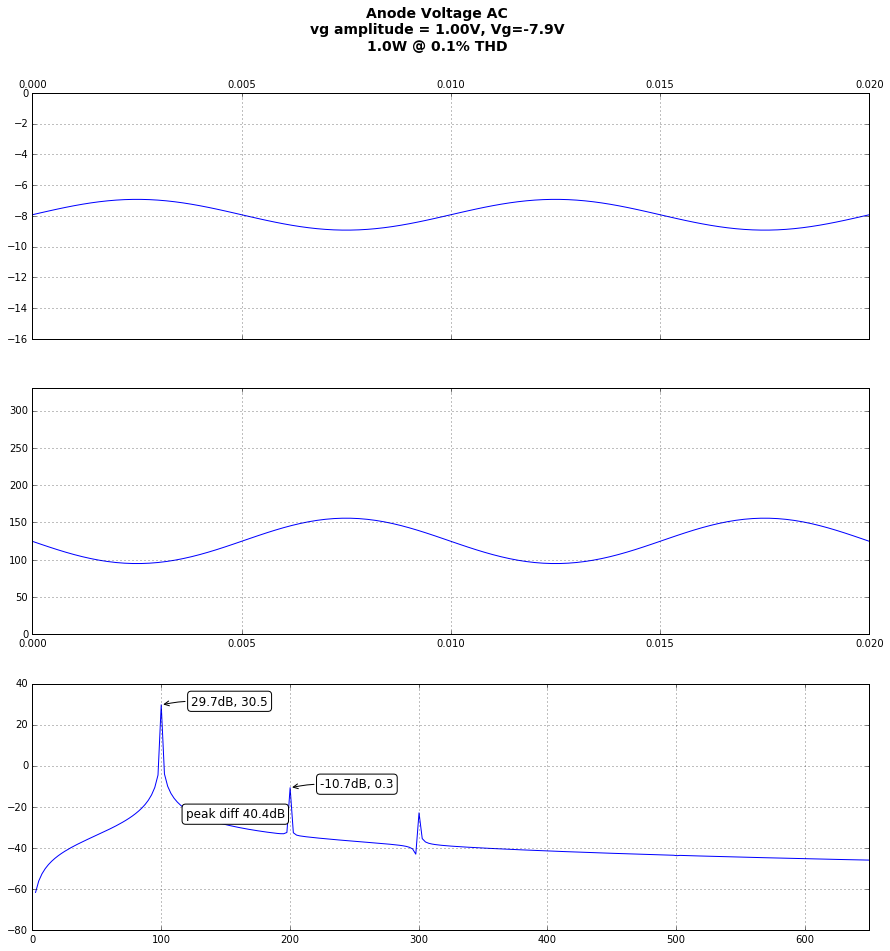

In [14]:
from scipy import signal

def plotTransient(vgamplitude):
    global vgLimitLow
    
    ra = Rl*n*n
    vaMax = -b/m

    N = 2000
    T = 1.0 / 5000.0
    f = 100.0

    t = np.linspace(0.0, N*T, N)
    vi = Vg + vgamplitude*np.sin(f*2.0*np.pi*t)
    ia = iaGet(vi)
    vo = vaMax - ia*ra
    
    yf = fft(vo)
    xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

    plt.figure(figsize=(15, 15))

    ax = plt.subplot(311)
    null = plt.xlim([0,0.02])
    null = plt.ylim([vgLimitLow,0])
    ax.plot(t,vi)
    ax.grid(True)
    ax.tick_params(axis='x', which='both', labeltop='on',labelbottom='off')

    ax = plt.subplot(312)
    null = plt.xlim([0,0.02])
    null = plt.ylim([0,vaMax])
    ax.plot(t,vo)
    ax.grid(True)
    
    ax = plt.subplot(313)
    yfl = 2.0/N * np.abs(yf[:N/2])
    ax.plot(xf[1:], 20*np.log10(yfl[1:])) # take the dc component off
    null = plt.xlim([0,650])
    ax.grid(True)
     
    mags = []
    for i in range(len(xf)):
        if xf[i]%100 < 1:
            mags.append(2.0/N*np.abs(yf[i]))
            # print xf[i],2.0/N*np.abs(yf[i])

    sum = 0
    for i in range(2,8):
        sum += mags[i]*mags[i]

    dist = 100*math.sqrt(sum)/mags[1]
    power = math.pow((mags[1]/n)/math.sqrt(2),2)/Rl

    null = plt.suptitle("Anode Voltage AC\nvg amplitude = %.2fV, Vg=%.1fV\n%.1fW @ %.1f%% THD"%(vgamplitude,Vg,dist,power),fontsize=14, fontweight='bold')

    try:
        peakind = signal.find_peaks_cwt(20*np.log10(yfl), np.arange(1,10))
        # print peakind, xf[peakind], yfl[peakind]

        # the peaks are off by 1 for some reason
        i1 = peakind[0]-1
        p1 = yfl[i1]
        p1l = 20 * np.log10(p1)

        i2 = peakind[1]-1
        p2 = np.abs(yfl[i2])
        p2l = 20 * np.log10(p2)

        null = plt.annotate(s="%.1fdB, %.1f"%(p1l,p1),
                    xy=(xf[i1],p1l),
                    xycoords='data',
                    xytext=(30,0),
                    textcoords='offset points',
                    bbox=dict(boxstyle="round", fc="1.0"),
                    size=12,
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="angle,angleA=0,angleB=10,rad=10"))
        null = plt.annotate(s="%.1fdB, %.1f"%(p2l,p2),
                    xy=(xf[i2],p2l),
                    xycoords='data',
                    xytext=(30,0),
                    textcoords='offset points',
                    bbox=dict(boxstyle="round", fc="1.0"),
                    size=12,
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="angle,angleA=0,angleB=10,rad=10"))

        null = plt.annotate(s="peak diff %.1fdB"%(abs(p1l-p2l)),
                    xy=((xf[i2]+xf[i1])/2,p2l),
                    xycoords='data',
                    xytext=(-40,-30),
                    textcoords='offset points',
                    bbox=dict(boxstyle="round", fc="1.0"),
                    size=12)
    except IndexError:
        pass # no peaks
    
    plt.show()
  
    
null = interact(plotTransient, vgamplitude=widgets.FloatSlider(min=0,max=30,step=0.25,value=1))

In [15]:
from IPython.display import HTML

# references
#   https://jakevdp.github.io/blog/2013/06/01/ipython-notebook-javascript-python-communication/
#   https://github.com/mdn/audio-buffer/blob/gh-pages/index.html
    
javascript = """
<script>
    var audioCtx = new (window.AudioContext || window.webkitAudioContext)();
    var pre = document.querySelector('pre');
    var myScript = document.querySelector('script');

    var channels = 2;
    var frameCount = audioCtx.sampleRate * 5.0;

    var myArrayBuffer = audioCtx.createBuffer(channels, frameCount, audioCtx.sampleRate);
    var play = function(Vg,vgamplitude,Ia,a0,a1,a2,a3,a4,a5,gain) {
      console.log(Vg,vgamplitude,Ia,a0,a1,a2)
      for (var channel = 0; channel < channels; channel++) {
       // This gives us the actual array that contains the data
       var nowBuffering = myArrayBuffer.getChannelData(channel);
       min = 100;
       max = -100;
       for (var k = 0; k < frameCount; k++) {
         // audio needs to be in [-1.0; 1.0]
         vi = Vg + vgamplitude*Math.sin(50*3.14*k);
         i = (a0*vi*vi*vi*vi*vi+a1*vi*vi*vi*vi+a2*vi*vi*vi+a3*vi*vi+a4*vi+a5);
         val = i*gain;
         if (val < min) {
             min = val;
         }
         if (val > max) {
             max = val;
         }
         nowBuffering[k] = val;
       }
       ave = (max+min)/2;
       for (var k = 0; k < frameCount; k++) {
           nowBuffering[k] -= ave;
       }
       console.log(nowBuffering);
      }

      var source = audioCtx.createBufferSource();
      source.buffer = myArrayBuffer;
      source.connect(audioCtx.destination);
      source.start();
    }
  </script>
"""

HTML(javascript)

In [16]:
# these 3 js buttons call the play function with Vg,vgamplitude,Ia,a0,a1,a2,gain where gain
# is set so fundamental has same amplitude, i.e. close to same loudness, so the user speaker
# amplifer doesn't distort and taint resulting audio.
# I use https://play.google.com/store/apps/details?id=com.zephyr.soundAnalyserPRO for spectrum
# display

# print Vg,Ia,coeff

input_form = """
<button onclick='play(%f,%f,%f,%f,%f,%f,%f,%f,%f,%f)' style="width:200px">Play vg=0.1Vpp</button><br>
<button onclick='play(%f,%f,%f,%f,%f,%f,%f,%f,%f,%f)' style="width:200px">Play vg=4pp</button><br>
<button onclick='play(%f,%f,%f,%f,%f,%f,%f,%f,%f,%f)' style="width:200px">Play vg=8pp</button><br>
<div id='buf'><div>
"""%(Vg,0.1,Ia,coeff[0],coeff[1],coeff[2],coeff[3],coeff[4],coeff[5],200.0,
     Vg,4,Ia,coeff[0],coeff[1],coeff[2],coeff[3],coeff[4],coeff[5],1,
     Vg,8,Ia,coeff[0],coeff[1],coeff[2],coeff[3],coeff[4],coeff[5],0.15)
HTML(input_form)

<hr>
<a href='https://play.google.com/store/apps/details?id=com.zephyr.soundAnalyserPRO'>Sound Analyser PRO</a><br>
<img src="../soundanalyser.png"/>

### References
#### Load Line
 * <a href='http://www.valvewizard.co.uk/se.html'>The Valve Wizard - The Single Ended Output Stage</a>
 * <a href='http://www.blueguitar.org/new/text/threads/from_mark/SBench_Loadlines_Series.pdf'>Steve Bench - Of Loadlines, Power Output and Distortion</a>

#### Harmonic Distortion Calculation
 * <a href='https://youtu.be/gMkSmlv9XbE?t=19m43s'>Tube Theory part 3 - Dennis Carter</a>
 * <a href='http://www.g8wrb.org/data//RCA/RC-22-Receiving-Tube-Manual.pdf'>RCA Receiving Tube Manual RC-22, p19</a>
 * <a href='http://www.tubebooks.org/Books/intro_reich.pdf'>Theory and Applications of Electron tubes - Reich, Section 3-20, p74 / Section 4-18, p115</a>